<a href="https://colab.research.google.com/github/JunHyeok-Navy/Machine_Learning/blob/main/Denoising_Diffusion_Probabilistic_Model_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.2 MB/s 


In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Denoising Diffusion Probabilistic Model with Tensorflow

# Abstract

<center><img src="https://hojonathanho.github.io/diffusion/assets/img/celebahq_combined_6.png" title="Generated by DDPM model" width="400"/></center> 

</br>

Thesedays, State-Of-The-Art Text-to-Image models show us high-quality generated images!  

When it comes to image generating model, we are familiar with GAN or VAE.  


Since 2020, research on the diffusion model has been actively conducted, and gradually, it shows performance that is comparable to GAN.

Espacially, google released SOTA Text-to-Image model ***'Imagen'*** and it is consisted of diffusion model architecture!


From now on, we will look at the basic contents of the **diffusion model** for advanced concepts of SOTA models and implement it through **Tensorflow**.

---

Reference Paper

- [Denoising Diffusion Probabilitics Model](https://arxiv.org/abs/2006.11239)
- [Deep Unsupervised Learning using Nonequilibrium Thermodynamics](https://arxiv.org/abs/1503.03585)


# Contents



1.  Introduction
2.  Mathematics & Workflow
3.  Implementation
4.  TPU Setting
5.  Data Processing
6.  Train Diffusion Model
7.  Evaluate Sample

# Introduction

<center><img src="https://i.imgur.com/WbwRmKH.jpg" title="Graphical Image" width="500"></center>

As you can see in the photo above, there is a **forward & backward** process in DDPM(Denoising Diffusion Probabilistic Model).

In forward process, model gradually add a little gaussian noise to original input image($x_0$ above) for numerous times.  
After adding noise for T(given steps) times, your original image will be filled with full of gaussian noise!

Then, DDPM find the way that restore changed noise-image to original image.  
***In a word, model is trained how "Backward Process" is work!***

### In the next chapter, we will learn more about the forward and backward processes and define the loss function and workflow to train the model.

 # Mathematics & Workflow

#### Prerequisite
- [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
- [Bayes' Theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)
- [Markov Chain](https://brilliant.org/wiki/markov-chains/)

You need a little bit mathematical knowledge in statistic & calculus.  
I'll not explain all about detail math lines in this notebook.  
You don't have to study whole thing. If there is a incomprehensible concept, you can search it at google or youtube for learning! 
There are so many good tutorials or resources. So don't worry about it :)

## Forward Process

$:=$ means 'define'.  

$$
\begin{aligned}
q(x_t|x_{t-1}) &:= N(x_t ; \sqrt{1-\beta_t}x_{t-1}, \beta_tI)\\
q(x_{1:T}|x_0) &:= \Pi_{t=1}^{T}{q(x_t|x_{t-1})}
\end{aligned}
$$

</br>

$\beta_t$ is the variance schedule which will be fixed to a constant.

Using [Reparameterization Trick](https://gregorygundersen.com/blog/2018/04/29/reparameterization/), we can sample $x_t$ using above definition.

$$
\begin{aligned}
q(x_t|x_{t-1}) &:= N(x_t ; \sqrt{1-\beta_t}x_{t-1}, \beta_tI)\\
x_t &= \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}z_{t-1} (Where, \alpha_t =1-\beta_t, \bar{α_t} = \Pi_{s=1}^{t}{}\alpha_s)\\
x_{t-1} &= \sqrt{\alpha_t \alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t \alpha_{t-1}}z_{t-2}\\
\therefore x_t &= \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}z
\end{aligned}$$

</br>

So, we can handle the sample at timestep $t$ with below.

<center>$q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t}I))$</center>

## Reverse Process

At the end of forward process, original image will be fully changed to a gaussian noise.  

$$p(x_T) = N(x_t; 0, I)$$  

We will predict the information (mean, variance) about the distribution of each forward process with a model, and we will represent the mean and variance of the reverse process with unknown functions, mu and sigma.  

$$
\begin{aligned}
p_{\theta}(x_{t-1}|x_t) &:= N(x_{t-1}; \mu(x_t, t), \Sigma_\theta (x_t, t))\\
p_\theta(x_{0:T}) &= p_\theta(x_T) \Pi_{t=1}^{T}{p_\theta(x_{t-1}|x_t)}\\
p_\theta(x_0) &:= \int p_\theta(x_{0:T})dx_{1:T}\\
\end{aligned}$$

## Loss

We can derive the final loss function through the following list.

- [Negative log likelihood](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)
- Evidence Lower Bound(ELBO)
- KL Divergence

### **There are so many math lines.. Hold tight!**
If you feel confused or cannot understand easily, contact me!
gylee206@gmail.com  

</br>

### <center>Let's begin!</center>   

## ***1) Define loss using negative log likelihood & ELBO***

</br>

$$
\begin{aligned}
log p_\theta(x_0) &= log{{p_\theta(x_0|x_{1:T})p_\theta(x_{1:T})}\over{p_\theta(x_{1:T}|x_0)}}\\
&= logp_\theta(x_0|x_{1:T}) + logp_\theta(x_{1:T})-logp_\theta(x_{1:T}|x_0)\\
E_q[logp_\theta(x_0)] &= \int{q(x_{1:T}|x_0)logp_\theta(x_0)}dx_{1:T}\\
&= \int{q(x_{1:T}|x_0)}[logp_\theta(x_0|x_{1:T}) + logp_\theta(x_{1:T}) - logp_\theta(x_{1:T}|x_0)]dx_{1:T}\\
&= E_q[logp_\theta(x_0|x_{1:T})] + \int{q(x_{1:T}|x_0)logp_\theta(x_{1:T})}dx_{1:T} - \int{q(x_{1:T}|x_0)logp_\theta(x_{1:T}|x_0)}dx_{1:T}\\
&= E_q[logp_\theta(x_0|x_{1:T})] + \int{q(x_{1:T}|x_0)logp_\theta(x_{1:T})}dx_{1:T} - \int{q(x_{1:T}|x_0)logp_\theta(x_{1:T}|x_0)}dx_{1:T} \\ &+ \int{q(x_{1:T}|x_0)logq(x_{1:T}|x_0)}dx_{1:T} - \int{q(x_{1:T}|x_0)logq(x_{1:T}|x_0)}dx_{1:T}\\
&= E_q[logp_\theta(x_0|x_{1:T})] -D_{KL}(q(x_{1:T}|x_0)||p(x_{1:T})) + D_{KL}(q(x_{1:T}|x_0)||p(x_{1:T}|x_0))\\
&≥ E_q[logp_\theta(x_0|x_{1:T})] -D_{KL}(q(x_{1:T}|x_0)||p(x_{1:T}))  (\because D_{KL} > 0)\\
E_q[-logp_\theta(x_0)] &≤  E_q[-logp_\theta(x_0|x_{1:T})] + D_{KL}(q(x_{1:T}|x_0)||p(x_{1:T}))\\
&=  E_q[-logp_\theta(x_0|x_{1:T})] +  E_q[logq(x_{1:T}|x_0)] -  E_q[logp_\theta(x_{1:T})]\\
&= -E_q[{log{{p_\theta(x_0|x_{1:T})p(x_{1:T})}\over{q(x_{1:T}|x_0)}}}]\\
\therefore -log p_\theta(x_0) &≤ -E_q[{log{{p_\theta(x_{0:T})}\over{q(x_{1:T|x_0})}}}]\\ (&\because logp_\theta(x_0|x_{1:T})p(x_{1:T}) = logp_\theta(x_{0:T}))
\end{aligned}
$$

</br>

### ***2) Change to tractable form***

</br>

$$
\begin{aligned}
At, -log p_\theta(x_0) &≤ -E_q[{log{{p_\theta(x_{0:T})}\over{q(x_{1:T|x_0})}}}]\\
E_q[-log{{p_\theta(x_{0:T})}\over{q(x_{1:T}|x_0)}}] &= E_q[-log{{p(x_T)\Pi_{t=1}^{T}{p(x_{t-1}|x_t)\over{q(x_t|x_{x_t-1})}}}}]\\
&= E_q[-logp_\theta(x_t)-\sum_{t=1}^{T}{log{{p_\theta(x_{t-1}|x_0)}\over{q(x_t|x_{t-1})}}}]\\
&= E_q[-logp_\theta(x_t)-\sum_{t=2}^{T}{log{{{p_\theta(x_{t-1}|x_0)}\over{q(x_t|x_{t-1})}}}} - log{{p_\theta(x_0|x_1)}\over{p_\theta(x_1|x_0)}}]\\
&= E_q[-logp_\theta(x_t)-\sum_{t=2}^{T}{log{{{p_\theta(x_{t-1}|x_0)q(x_{t-1}|x_0)}}\over{q(x_{t-1}|x_t, x_0)q(x_t|x_0)}}} - log{{p_\theta(x_0|x_1)}\over{q(x_1|x_0)}}]\\
&= E_q[-logp_\theta(x_t)-\sum_{t=2}^{T}{log{{{p_\theta(x_{t-1}|x_0)}}\over{q(x_{t-1}|x_t, x_0)}}} - log{{q(x_1|x_0)}\over{x_T|x_0}} - log{{p_\theta(x_0|x_1)}\over{q(x_1|x_0)}}]\\
&= E_q[-log{{p_\theta(x_t)}\over{q(x_T|x_0)}}-\sum_{t=2}^{T}{log{{{p_\theta(x_{t-1}|x_0)}}\over{q(x_{t-1}|x_t, x_0)}}} - log{{p_\theta(x_0|x_1)}}]\\
&= E_q[D_{KL}(q(x_T|x_0)||p_\theta(x_T)) + \sum_{t=2}^{T}{D_{KL}(q(x_{t-1}|x_t, x_0)||p(x_{t-1}|x_t)} - logp_\theta(x_0|x_1)]
\end{aligned}
$$

</br>

As $\beta_t$ is not scheduled, just fixed to a constant value, $E_q[D_{KL}(q(x_T|x_0)||p_\theta(x_T))$ is also constant

</br>

### ***3) Simplify training objective!***

We will use $D_{KL}(q(x_{t-1}|x_t, x_0)||p_\theta(x_{t-1}|x_t)))$ for simplifing loss function.  
In the paper, the author trained model the part just mentioned by setting it as a training object.  

</br>

So, our challenge has been narrowed down to training the two distributions($q(x_{t-1}|x_t, x_0), p_\theta(x_{t-1}|x_t)$) as equally as possible.

</br>

$$
\begin{aligned}
q(x_{t-1}|x_t, x_0) &= N(x_{t-1}; \hat{\mu}(x_t, x_0), \hat{\beta}I)\\
p_\theta(x_{t-1}|x_t) &= N(x_{t-1}; \mu_\theta(x_t, t), {\sigma_t}^2 I)
\end{aligned}
$$

</br>

$$
\begin{aligned}
D_{KL}(q(x_{t-1}|x_t, x_0)||p_\theta(x_{t-1}|x_t))) &= E_{x_0, \epsilon}[{{{\beta_t}^2}\over{2{\sigma_t}^2 \alpha_t (1- {\hat{\alpha_t}})}}\left \|  \epsilon-\epsilon_\theta(\sqrt{\hat{\alpha_t}}x_0 + \sqrt{1-\hat{\alpha_t}}\epsilon, t)\right \|^2]\\
\end{aligned}
$$

${{{\beta_t}^2}\over{2{\sigma_t}^2 \alpha_t (1- {\hat{\alpha_t}})}}$ is considered as a constant in the paper

<center>Final Loss : $E_{x_0, \epsilon}[\left \|  \epsilon-\epsilon_\theta(\sqrt{\hat{\alpha_t}}x_0 + \sqrt{1-\hat{\alpha_t}}\epsilon, t)\right \|^2]$</center>

# Implementation

In [3]:
import math
import numpy as np
from inspect import isfunction
import tensorflow as tf
import tensorflow.keras.layers as nn
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras import Sequential
from tensorflow import einsum
from einops import rearrange
from einops.layers.tensorflow import Rearrange

## Diffusion Model

In [4]:
def gather(c, t):
  c = tf.gather(c, t)
  return tf.reshape(c, [-1, 1, 1, 1])

class DiffusionModel:
  def __init__(self, model, n_steps):
    super().__init__()
    self.eps_model = model
    self.beta = tf.linspace(1e-4, 2e-2, n_steps)
    self.alpha = 1. - self.beta
    self.alpha_hat = tf.math.cumprod(self.alpha, axis=0)
    self.n_steps = n_steps
    self.sigma = self.beta

  def forward_process(self, x_0, t):
    mean = gather(self.alpha_hat, t) ** 0.5 *x_0
    variance = 1 - gather(self.alpha_hat, t)
    return mean, variance

  def forward_sample(self, x_0, t, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=x_0.shape)
    mean, variance = self.forward_process(x_0, t)
    return mean + (variance**0.5)*eps

  def reverse_sample(self, x_t, t):
    eps_theta = self.model(x_t, t)
    alpha_hat = gather(self.alpha_hat, t)
    alpha = gather(self.alpha, t)
    eps_coef = (1-alpha) / (1-alpha_hat)**0.5

    mean = 1 / (alpha**0.5)*(x_t - eps_coef*eps_theta)
    variance = gather(self.sigma, t)
    eps = tf.random.normal(shape=x_t.shape)
    return mean+(variance**0.5)*eps

  def loss(self, x_0, noise):
    batch_size = x_0.shape[0]
    t = tf.random.uniform(shape=[batch_size], minval=0, maxval=self.n_steps, dtype=tf.dtypes.int32)
    if noise is None:
      noise = tf.random.normal(shape=x_0.shape)
    x_t = self.forward_sample(x_0, t, eps=noise)
    eps_theta = self.model(x_t, t)
    return tf.losses.mse(noise, eps_theta)

## U-Net Model for $\epsilon_\theta$

<img src="https://nn.labml.ai/diffusion/ddpm/unet.png" title="U-Net" width=500>

This implementation contains a bunch of modifications to original U-Net  
(residual blocks, multi-head attention) and also adds time-step embeddings t.

### Helper Functions

In [5]:
# helpers functions
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def cycle(dl):
    while True:
        for data in dl:
            yield data

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# small helper modules
class Identity(Layer):
    def __init__(self):
        super(Identity, self).__init__()

    def call(self, x, training=True):
        return tf.identity(x)

class EMA(Layer):
    def __init__(self, beta=0.995):
        super(EMA, self).__init__()
        self.beta = beta

    @tf.function
    def update_model_average(self, old_model, new_model):
        for old_weight, new_weight in zip(old_model.weights, new_model.weights):
            assert old_weight.shape == new_weight.shape

            old_weight.assign(self.update_average(old_weight, new_weight))

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

# Residual Func
class Residual(Layer):
    def __init__(self, fn):
        super(Residual, self).__init__()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(x, training=training) + x

# U-Net TimeEmbedding
class SinusoidalPosEmb(Layer):
    def __init__(self, dim, max_positions=10000):
        super(SinusoidalPosEmb, self).__init__()
        self.dim = dim
        self.max_positions = max_positions

    def call(self, x, training=True):
        x = tf.cast(x, tf.float32)
        half_dim = self.dim // 2
        emb = math.log(self.max_positions) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = x[:, None] * emb[None, :]

        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=-1)

        return emb

def Upsample(dim):
    return nn.Conv2DTranspose(filters=dim, kernel_size=4, strides=2, padding='SAME')

def Downsample(dim):
    return nn.Conv2D(filters=dim, kernel_size=4, strides=2, padding='SAME')

class LayerNorm(Layer):
    def __init__(self, dim, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.eps = eps

        self.g = tf.Variable(tf.ones([1, 1, 1, dim]))
        self.b = tf.Variable(tf.zeros([1, 1, 1, dim]))

    def call(self, x, training=True):
        var = tf.math.reduce_variance(x, axis=-1, keepdims=True)
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)

        x = (x - mean) / tf.sqrt((var + self.eps)) * self.g + self.b
        return x

class PreNorm(Layer):
    def __init__(self, dim, fn):
        super(PreNorm, self).__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def call(self, x, training=True):
        x = self.norm(x)
        return self.fn(x)

class SiLU(Layer):
    def __init__(self):
        super(SiLU, self).__init__()

    def call(self, x, training=True):
        return x * tf.nn.sigmoid(x)

def gelu(x, approximate=False):
    if approximate:
        coeff = tf.cast(0.044715, x.dtype)
        return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
    else:
        return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))


class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x, training=True):
        return gelu(x, self.approximate)

def linear_beta_schedule(timesteps):
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02

    return tf.cast(tf.linspace(beta_start, beta_end, timesteps), tf.float32)

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = tf.cast(tf.linspace(0, timesteps, steps), tf.float32)

    alphas_cumprod = tf.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])

    return tf.clip_by_value(betas, 0, 0.999)

def extract(x, t):
    return tf.gather(x, t)[:, None, None, None]

### Block Modules

In [6]:
# building block modules
class Block(Layer):
    def __init__(self, dim, groups=8):
        super(Block, self).__init__()
        self.proj = nn.Conv2D(dim, kernel_size=3, strides=1, padding='SAME')
        self.norm = tfa.layers.GroupNormalization(groups, epsilon=1e-05)
        self.act = SiLU()

    def call(self, x, scale_shift=None, training=True):
        x = self.proj(x)
        x = self.norm(x, training=training)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(Layer):
    def __init__(self, dim, dim_out, time_emb_dim=None, groups=8):
        super(ResnetBlock, self).__init__()

        self.mlp = Sequential([
            SiLU(),
            nn.Dense(units=dim_out * 2)
        ]) if exists(time_emb_dim) else None

        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = nn.Conv2D(filters=dim_out, kernel_size=1, strides=1) if dim != dim_out else Identity()

    def call(self, x, time_emb=None, training=True):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b 1 1 c')
            scale_shift = tf.split(time_emb, num_or_size_splits=2, axis=-1)

        h = self.block1(x, scale_shift=scale_shift, training=training)
        h = self.block2(h, training=training)

        return h + self.res_conv(x)

class LinearAttention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(LinearAttention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.attend = nn.Softmax()
        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)

        self.to_out = Sequential([
            nn.Conv2D(filters=dim, kernel_size=1, strides=1),
            LayerNorm(dim)
        ])

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)

        q = tf.nn.softmax(q, axis=-2)
        k = tf.nn.softmax(k, axis=-1)

        q = q * self.scale
        context = einsum('b h d n, b h e n -> b h d e', k, v)

        out = einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b x y (h c)', h=self.heads, x=h, y=w)
        out = self.to_out(out, training=training)

        return out

class Attention(Layer):
    def __init__(self, dim, heads=4, dim_head=32):
        super(Attention, self).__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        self.hidden_dim = dim_head * heads

        self.to_qkv = nn.Conv2D(filters=self.hidden_dim * 3, kernel_size=1, strides=1, use_bias=False)
        self.to_out = nn.Conv2D(filters=dim, kernel_size=1, strides=1)

    def call(self, x, training=True):
        b, h, w, c = x.shape
        qkv = self.to_qkv(x)
        qkv = tf.split(qkv, num_or_size_splits=3, axis=-1)
        q, k, v = map(lambda t: rearrange(t, 'b x y (h c) -> b h c (x y)', h=self.heads), qkv)
        q = q * self.scale

        sim = einsum('b h d i, b h d j -> b h i j', q, k)
        sim_max = tf.stop_gradient(tf.expand_dims(tf.argmax(sim, axis=-1), axis=-1))
        sim_max = tf.cast(sim_max, tf.float32)
        sim = sim - sim_max
        attn = tf.nn.softmax(sim, axis=-1)

        out = einsum('b h i j, b h d j -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b x y (h d)', x = h, y = w)
        out = self.to_out(out, training=training)

        return out

class MLP(Layer):
    def __init__(self, hidden_dim):
        super(MLP, self).__init__()
        self.net = Sequential([
            Rearrange('... -> ... 1'), # expand_dims(axis=-1)
            nn.Dense(units=hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units=hidden_dim),
            GELU(),
            LayerNorm(hidden_dim),
            nn.Dense(units=hidden_dim),
        ])

    def call(self, x, training=True):
        return self.net(x, training=training)

### U-Net Model

In [9]:
from functools import partial
from tqdm import tqdm

class Unet(Model):
    def __init__(self,
                 dim=64,
                 init_dim=None,
                 out_dim=None,
                 dim_mults=(1, 2, 4, 8),
                 channels=3,
                 resnet_block_groups=8,
                 learned_variance=False,
                 sinusoidal_cond_mlp=True
                 ):
        super(Unet, self).__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2D(filters=init_dim, kernel_size=7, strides=1, padding='SAME')

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings
        time_dim = dim * 4
        self.sinusoidal_cond_mlp = sinusoidal_cond_mlp

        if sinusoidal_cond_mlp:
            self.time_mlp = Sequential([
                SinusoidalPosEmb(dim),
                nn.Dense(units=time_dim),
                GELU(),
                nn.Dense(units=time_dim)
            ])
        else:
            self.time_mlp = MLP(time_dim)

        # layers
        self.downs = []
        self.ups = []
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append([
                block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Downsample(dim_out) if not is_last else Identity()
            ])
        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append([
                block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Upsample(dim_in) if not is_last else Identity()
            ])

        default_out_dim = channels * (1 if not learned_variance else 2)
        self.out_dim = default(out_dim, default_out_dim)

        self.final_conv = Sequential([
            block_klass(dim * 2, dim),
            nn.Conv2D(filters=self.out_dim, kernel_size=1, strides=1)
        ])

    def call(self, x, time=None, training=True, **kwargs):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = tf.concat([x, h.pop()], axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = tf.concat([x, h.pop()], axis=-1)
        x = self.final_conv(x)
        return x

## Model Test!

In [10]:
unet = Unet()
diffusion = DiffusionModel(unet, 1000)

In [ ]:
dataset = tfds.load('cifar10')

In [16]:
sample = next(iter(dataset['train']))['image'].numpy()

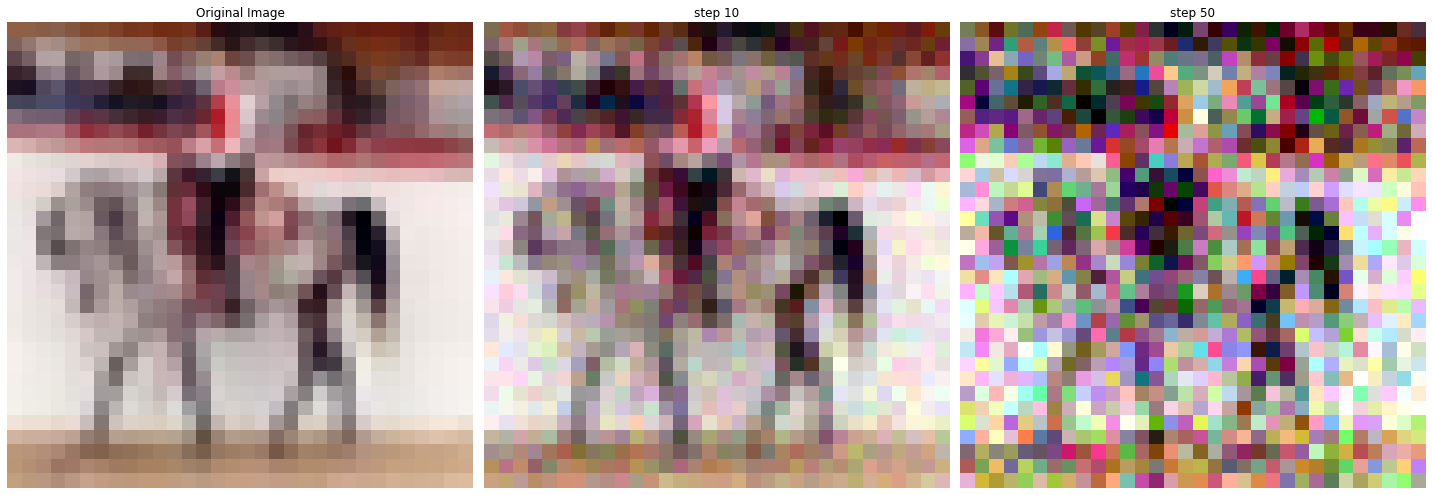

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(sample/255.)
ax1.set_title('Original Image')
ax1.axis("off")

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(diffusion.forward_sample(sample/255., 10).numpy().reshape([32,32,3]))
ax2.set_title('step 10')
ax2.axis("off")

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(diffusion.forward_sample(sample/255., 50).numpy().reshape([32,32,3]))
ax3.set_title('step 50')
ax3.axis('off')

plt.tight_layout()

In [ ]:
plt.imshow(diffusion.forward_sample(sample/255., 100).numpy().reshape(32, 32, 3))